In [60]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import numpy.ma as ma

%matplotlib inline
%config InlineBackend.figure_format = "retina"
from tqdm import tqdm

from matplotlib import rcParams
rcParams["savefig.dpi"] = 100
rcParams["font.size"] = 20

from lsst.rsp import get_tap_service, retrieve_query
service = get_tap_service()

from astropy.cosmology import WMAP9 as cosmo
import astropy.units as u
from tqdm import tqdm 

In [61]:
# create the TAP service client
service = get_tap_service()

# we will all use the same input coordinates and radii
center_coords = "62, -37"

radius_deg = 1 # degrees

## Scope

In this notebook we would like to investigate if there's a difference in the time-series features...

For example: 

Other future:
See here my discussion with Eric: 

	run existing timeseries feature code on totFlux, and forced diff and forced totFluxes?

	some further discussion.  Eric thinks that we can run eg. Lomb-Scargle on the forced *difference* flux since the zero-level doesn't matter and it avoids crowding issues.
    
	maybe that speaks to providing only ~one offset between the diff and science/totFluxes?  (e.g., report the median for both?) 
    
    Then in principle it's a simple addition/conversion to get the apparent mags.
	we can test by looking at trends in residuals of diff and tot fluxes--how much do they differ from a constant?


In [219]:
rad = 1

results = service.search("SELECT ra, decl, gPSFluxSigma, rPSFluxSigma, nDiaSources, diaObjectId, "
                         "uPSFluxNdata, gPSFluxNdata, rPSFluxNdata, iPSFluxNdata, zPSFluxNdata, yPSFluxNdata, rPSFluxMax, "
                         "scisql_nanojanskyToAbMag(uPSFluxMax) as u_psf_mag, "
                         "scisql_nanojanskyToAbMag(gPSFluxMax) as g_psf_mag, "
                         "scisql_nanojanskyToAbMag(rPSFluxMax) as r_psf_mag, "
                         "scisql_nanojanskyToAbMag(iPSFluxMax) as i_psf_mag, "
                         "scisql_nanojanskyToAbMag(zPSFluxMax) as z_psf_mag, "
                         "scisql_nanojanskyToAbMag(yPSFluxMax) as y_psf_mag "
                         "FROM dp02_dc2_catalogs.DiaObject "
                         "WHERE CONTAINS(POINT('ICRS', ra, decl), "
                         f"CIRCLE('ICRS', {center_coords}, {rad})) = 1 "
                        "AND uPSFluxChi2 > 0 "
                        "AND gPSFluxChi2 > 0 "
                        "AND rPSFluxChi2 > 0 "
                        "AND iPSFluxChi2 > 0 "
                        "AND zPSFluxChi2 > 0 "
                        "AND yPSFluxChi2 > 0 ")

table = results.to_table()

In [220]:
len(table)

2044

In [297]:
XX, YY = [], []
for j in tqdm(table['diaObjectId']):

    q = service.search("SELECT totFlux, filterName, midPointTai, psFlux "
                      "FROM dp02_dc2_catalogs.DiaSource "
                      "WHERE CONTAINS(POINT('ICRS', ra, decl), "
                    f"CIRCLE('ICRS', {center_coords}, {rad})) = 1 "
                      f"AND diaObjectId = {j}")

    tab2 = q.to_table()
    
    XX.append(tab2['psFlux'][tab2['filterName']=='g'].data.data)
    YY.append(tab2['totFlux'][tab2['filterName']=='g'].data.data)

    #plt.scatter((tab2['psFlux'][tab2['filterName']=='r']), (tab2['totFlux'][tab2['filterName']=='r']), 
    #           color='k')
    #plt.yscale('log')
    #plt.xscale('log')

100%|██████████| 2044/2044 [05:01<00:00,  6.79it/s]


In [298]:
XX, YY = np.concatenate(XX), np.concatenate(YY)

In [299]:
rm1 = ~np.isnan(XX)


XX = XX[rm1]
YY  = YY[rm1]

rm2 = ~np.isnan(YY)

XX = XX[rm2]
YY  = YY[rm2]

In [304]:
J = np.histogram2d(XX, YY, bins=(150, 150))

/tmp/ipykernel_1856/3218349116.py:2: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(J[0].T),


Text(0, 0.5, 'totFlux$_{r}$')

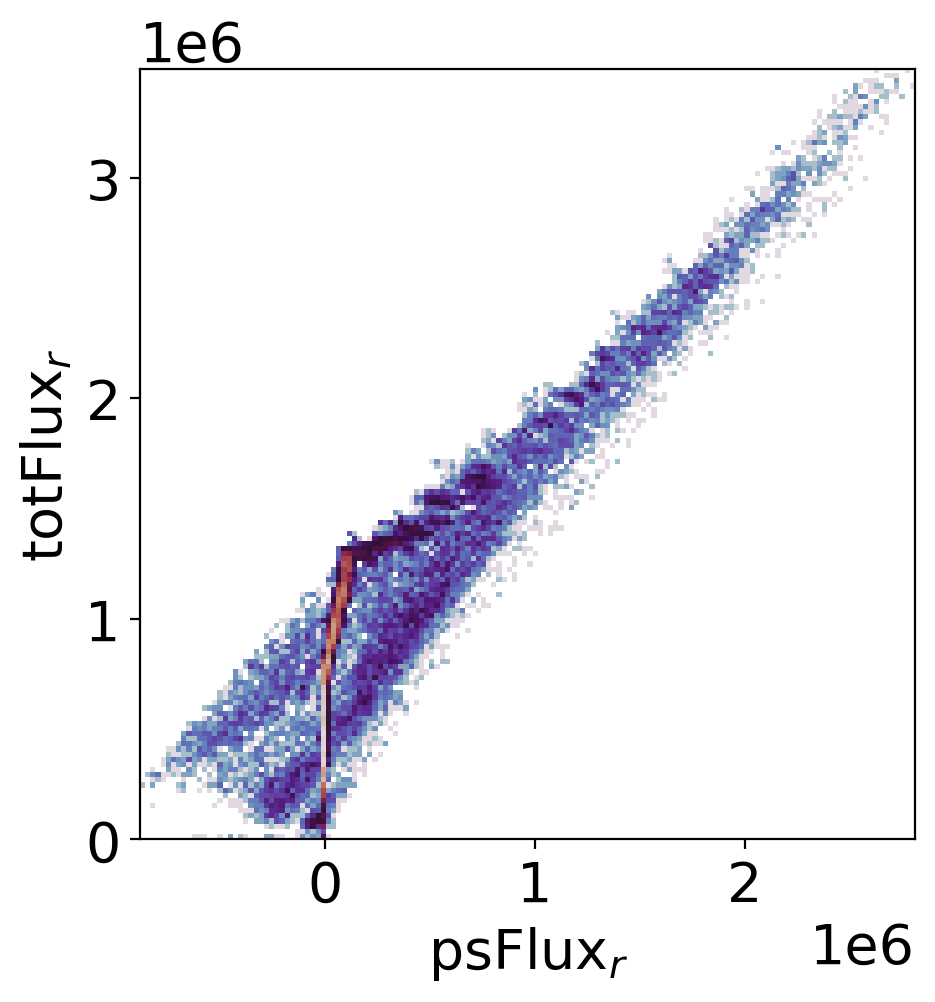

In [306]:
plt.figure(figsize=(5,5))
plt.imshow(np.log10(J[0].T), 
          aspect='auto', 
          origin='lower', 
          cmap='twilight', 
          extent=[XX.min(), XX.max(), YY.min(), YY.max()], 
          vmin=0, vmax=3)

#plt.plot(np.linspace(min(XX), max(XX), 2100), np.linspace(min(YY), max(YY), 2100), 
#        color='k', ls='--')


plt.xlabel('psFlux$_{r}$')
plt.ylabel('totFlux$_{r}$')

In [307]:
line = lambda x, a, b: x*a + b

line = lambda x, a, b: x*a + b
line = lambda x, a, b: x*a + b

Text(0.5, 1.0, 'totFlux light curve of 1651220174314930183')

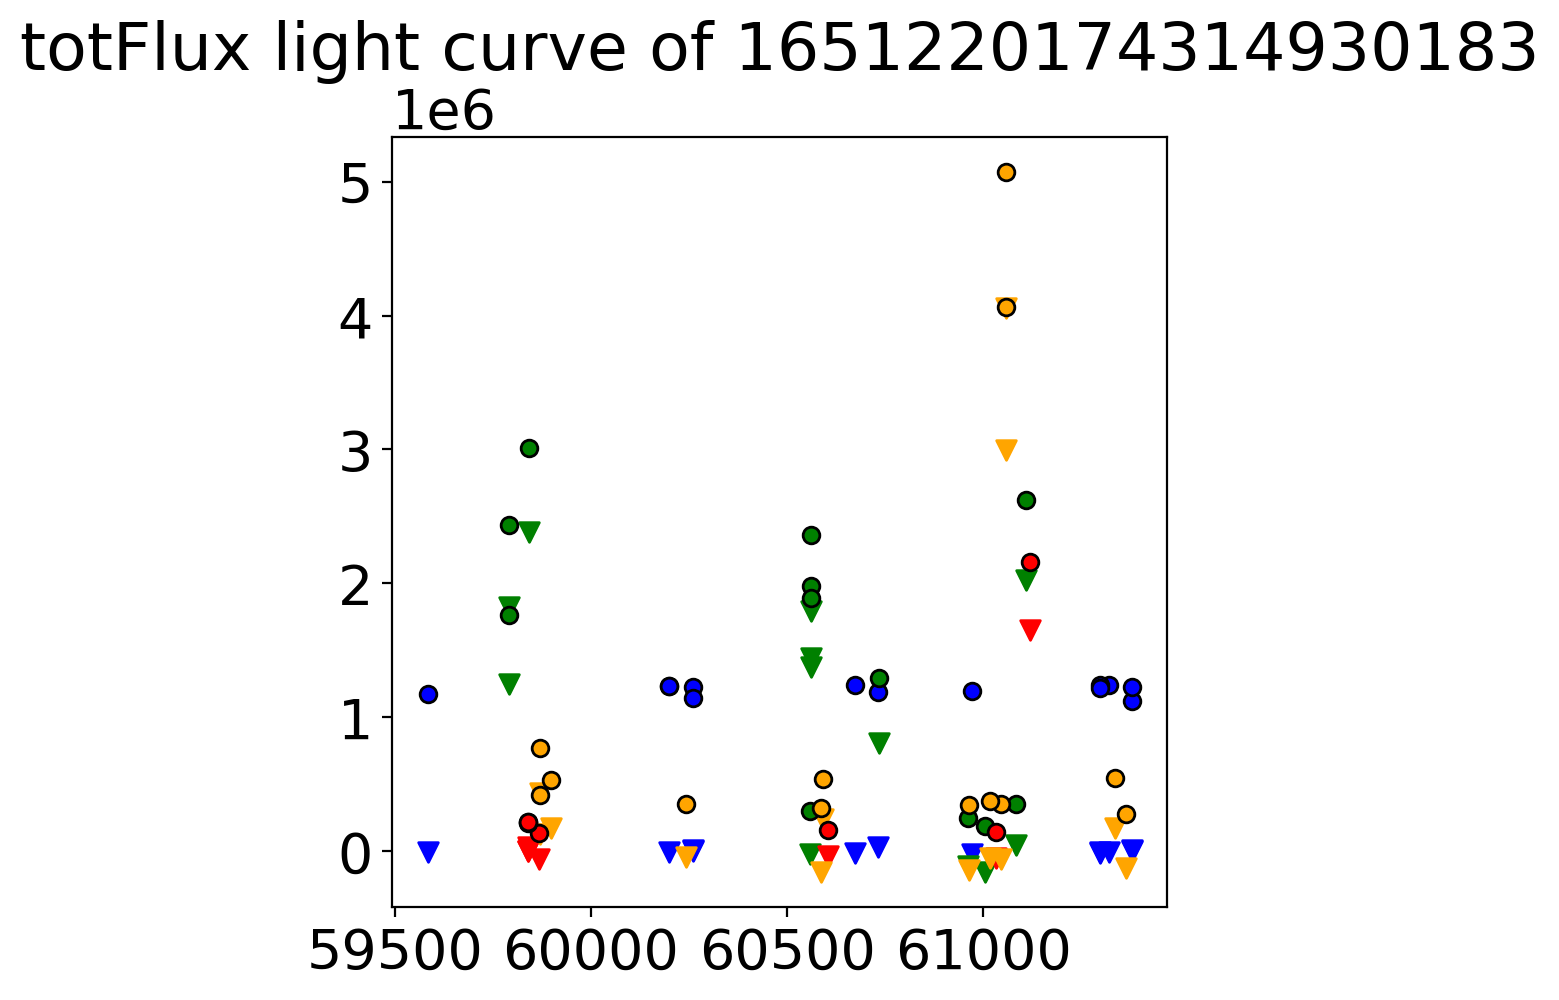

In [164]:
plt.figure(figsize=(5,5))
plt.scatter(tab2['midPointTai'][tab2['filterName']=='u'], tab2['psFlux'][tab2['filterName']=='u'], color='blue', s=50, marker='v')
plt.scatter(tab2['midPointTai'][tab2['filterName']=='g'], tab2['psFlux'][tab2['filterName']=='g'], color='green', s=50, marker='v')
plt.scatter(tab2['midPointTai'][tab2['filterName']=='r'], tab2['psFlux'][tab2['filterName']=='r'], color='red', s=50, marker='v')
plt.scatter(tab2['midPointTai'][tab2['filterName']=='i'], tab2['psFlux'][tab2['filterName']=='i'], color='orange', s=50, marker='v')
plt.title("psFlux light curve of 1651220174314930183")



plt.scatter(tab2['midPointTai'][tab2['filterName']=='u'], tab2['totFlux'][tab2['filterName']=='u'], color='blue', edgecolor='k')
plt.scatter(tab2['midPointTai'][tab2['filterName']=='g'], tab2['totFlux'][tab2['filterName']=='g'], color='green', edgecolor='k')
plt.scatter(tab2['midPointTai'][tab2['filterName']=='r'], tab2['totFlux'][tab2['filterName']=='r'], color='red', edgecolor='k')
plt.scatter(tab2['midPointTai'][tab2['filterName']=='i'], tab2['totFlux'][tab2['filterName']=='i'], color='orange', edgecolor='k')
plt.title("totFlux light curve of 1651220174314930183")

In [55]:
sel_objid = 1651220174314930183

# From Tutorial 07b to fetch the light curve information
query = "SELECT src.band, src.ccdVisitId, src.coord_ra, src.coord_dec, src.tract, src.patch, "\
        "src.objectId, src.psfFlux, src.psfFluxErr, "\
        "scisql_nanojanskyToAbMag(psfFlux) as psfMag, "\
        "visinfo.ccdVisitId, visinfo.band, "\
        "visinfo.expMidptMJD, visinfo.zeroPoint "\
        "FROM dp02_dc2_catalogs.ForcedSource as src "\
        "JOIN dp02_dc2_catalogs.CcdVisit as visinfo "\
        "ON visinfo.ccdVisitId = src.ccdVisitId "\
        "WHERE src.objectId = "+str(sel_objid)+" "

# Query 
results = service.search(query)
lc = results.to_table() # light curve table

In [70]:
#plt.scatter(lc['expMidptMJD'][lc['band']=='r'], lc['psfFlux'][lc['band']=='r'])
print (np.median(lc['psfFlux'][lc['band']=='r']))

1571.4834706


/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-5.1.0/lib/python3.10/site-packages/numpy/core/fromnumeric.py:755: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


In [126]:
lc[0]

band,ccdVisitId,coord_ra,coord_dec,tract,patch,objectId,psfFlux,psfFluxErr,psfMag,ccdVisitId2,band2,expMidptMJD,zeroPoint
,,deg,deg,,,,nJy,nJy,,,,d,mag
object,int64,float64,float64,int64,int64,int64,float64,float64,float64,int64,object,float64,float32
r,193836114,62.1697192,-37.2219071,3831,3,1651220174314930183,1573.5322353,128.0504947,23.407810889313325,193836114,r,59840.2416692,32.1756


In [123]:
ss = service.search("SELECT psfFlux, psfFluxErr, tract, patch, diaObjectId, coord_ra, coord_dec, ccdVisitId, band "
                   "FROM dp02_dc2_catalogs.ForcedSourceOnDiaObject "
                   "WHERE CONTAINS(POINT('ICRS', coord_ra, coord_dec), "
                   f"CIRCLE('ICRS', {center_coords}, {0.25})) = 1 "
                   "AND tract = 3831 AND patch = 3")

tt = ss.to_table()

In [124]:

ww = np.where((tt['diaObjectId']==1651220174314932313) & (tt['band']=='r'))

len(tt[ww]['psfFlux'])

112

In [125]:
tt[ww]

psfFlux,psfFluxErr,tract,patch,diaObjectId,coord_ra,coord_dec,ccdVisitId,band
nJy,nJy,,,,deg,deg,,
float64,float64,int64,int64,int64,float64,float64,int64,object
147.7555213,125.6253095,3831,3,1651220174314932313,62.2434457,-37.1206708,1190763091,r
378.0751022,175.8001936,3831,3,1651220174314932313,62.2434457,-37.1206708,909813161,r
-231.7610278,237.1786113,3831,3,1651220174314932313,62.2434457,-37.1206708,456745013,r
-4.6330315,188.6961094,3831,3,1651220174314932313,62.2434457,-37.1206708,694315103,r
-115.9991863,219.4060246,3831,3,1651220174314932313,62.2434457,-37.1206708,733758028,r
88.0577663,188.0741083,3831,3,1651220174314932313,62.2434457,-37.1206708,942613006,r
-149.192457,162.9312366,3831,3,1651220174314932313,62.2434457,-37.1206708,943325062,r
27.1354077,116.2728473,3831,3,1651220174314932313,62.2434457,-37.1206708,1188376006,r
